# Data Exploration and Clean up
Looking at Vaccination rates per county and county cross-referenced with demographic data to look for any correlations.
## Exploration Questions
What does the vaccination rate look like accross California

What relationship (if any) do the folowing variables have on the vaccination rates accross countries.
- Median Income
- County Education Level
- Unemployment Level
- Percent Uninsured
- County Population

## Data being used
- Kindergarten Immunization records from Kaggle [link](https://www.kaggle.com/broach/california-kindergarten-immunization-rates)
- CA census estimates currated by the state [link](http://www.dof.ca.gov/Reports/Demographic_Reports/American_Community_Survey/#ACS2017x5)

# Imports

## Modules and Environment

In [1]:
# Calculation
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Modules
import subprocess
from functools import reduce

get_ipython().run_line_magic('config', 'IPCompleter.greedy = True')

## Import data and basic cleaning of Data

### Immunization Records

#### Key for the table
- schoolType - Public/Private indicator
- COUNTY - name of county in CA
- SCHOOL - String label of school (not always consistent across years)
- school_code - Unique integer code for each school (consistent across years)
- n - Number of students
- nMMR - Number of students reporting complete MMR vaccination
- nDTP - Number of students reporting DTP vaccination
- nPolio - Number of students reporting Polio vaccination
- nPBE - Number of students reporting personal beliefs exemption*
- nPME - Number of students reporting permanent medical exemption
- year - Calendar year (2000:2014) where 2000=2000-2001 school year, 2001=2001-2002 school year, etc.

In [2]:
# Import immunization records
student_df = pd.read_csv('data/california-kindergarten-immunization-rates/StudentData.csv', sep=None, engine='python')
student_df.head()

,schoolType,COUNTY,SCHOOL,school_code,n,nMMR,nDTP,nPolio,nPBE,nPME,year
0,PRIVATE,ALAMEDA,A CHILD'S WORLD MONTE,7092463,12,12,11,9,0,0,2000
1,PRIVATE,ALAMEDA,ACAD,6972533,15,15,15,15,0,0,2000
2,PRIVATE,ALAMEDA,ACTS CHRISTIAN ACADEM,7082266,19,17,17,17,0,0,2009
3,PRIVATE,ALAMEDA,ACTS CHRISTIAN ACADEM,7082266,23,6,22,23,0,0,2010
4,PRIVATE,ALAMEDA,ACTS CHRISTIAN ACADEM,7082266,27,27,27,27,0,0,2006


In [3]:
# Narrow down to the years we have demo data
student_df = student_df[(student_df['year'] > 2009) & (student_df['year'] < 2015)]
student_df['year'].unique()

array([2010, 2012, 2011, 2014, 2013])

In [4]:
# Aggregate the student_df
student_df['exemptions'] = student_df['nPBE'] + student_df['nPME']
student_agg = student_df.groupby('COUNTY')['n', 'exemptions'].sum()

# Format it
student_agg = student_agg.reset_index()
student_agg = student_agg.rename(columns={'COUNTY': 'County'})
student_agg['County'] = student_agg['County'].str.title()

# Find the percent vacinated
student_agg['Percent Vaccinated'] = round((student_agg['n'] - student_agg['exemptions']) / student_agg['n'] * 100, 2)

display(student_agg.head())
display(student_agg.describe())

,County,n,exemptions,Percent Vaccinated
0,Alameda,96934,1594,98.36
1,Alpine,56,3,94.64
2,Amador,1465,85,94.20
3,Butte,13052,759,94.18
4,Calaveras,2025,174,91.41


,n,exemptions,Percent Vaccinated
count,58.000000,58.000000,58.000000
mean,45126.844828,1248.482759,95.283966
std,94967.489473,2156.439929,3.772534
min,56.000000,2.000000,79.860000
25%,2241.000000,140.250000,92.812500
50%,12741.000000,517.000000,96.305000
75%,43476.000000,1480.500000,98.122500
max,643340.000000,12228.000000,99.560000


### Demographic Data

In [5]:
def filter_by_county(df):
    new_df = df.loc[df['Geography'].str.contains('County')]
    new_df = new_df.loc[~new_df['Geography'].str.contains('\(')]
    new_df['Geography'] = new_df['Geography'].str.replace(' County', '')
    new_df = new_df.rename(columns={'Geography': 'County'})
    return new_df

In [6]:
# Import Education Data
education_df = pd.read_excel('data/Web_ACS2014_10_Educ.xlsx', sheet_name='Educational Attainment', header=[4,5])

# Clean up the cols
education_df = education_df.rename(columns={'Unnamed: 0_level_0': 'Geography'})
education_df = education_df[["Geography", "Percent Less than 9th grade", "Percent 9th to 12th grade, no diploma", "Percent High school graduate (includes equivalency)", 
                             "Percent Bachelor's degree", "Percent Graduate or professional degree",
                             "Percent high school graduate or higher", "Percent bachelor's degree or higher"]]
education_df = education_df.drop(columns=['Margin of Error', 'Margin of Error.1', 'Summary Level', 'County', 'Place'], level=1)

education_df.columns = ['Geography', '9th or less', '9th-12th', "High School Graduate", 'Bachelors', 'Graduate Degree', 'High School or Higher', 'Bachelors or Higher']
education_df['No High School Diploma'] = education_df['9th or less'] + education_df['9th-12th']
education_df = education_df.drop(columns=['9th or less', '9th-12th'])
# Filter down to the county level
education_df = filter_by_county(education_df)

education_df.head()

,County,High School Graduate,Bachelors,Graduate Degree,High School or Higher,Bachelors or Higher,No High School Diploma
1,Alameda,18.9,24.6,17.5,86.7,42.1,13.3
22,Alpine,29.3,18.2,12.4,91.4,30.5,8.5
28,Amador,27.5,14.3,6.2,88.4,20.5,11.7
47,Butte,23.5,16.7,8.4,88,25,12
78,Calaveras,27,15,6.1,92.5,21.1,7.5


In [7]:
education_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 1 to 1567
Data columns (total 7 columns):
County                    58 non-null object
High School Graduate      58 non-null object
Bachelors                 58 non-null object
Graduate Degree           58 non-null object
High School or Higher     58 non-null object
Bachelors or Higher       58 non-null object
No High School Diploma    58 non-null object
dtypes: object(7)
memory usage: 3.6+ KB


In [8]:
# Import Health Insurance Data
health_ins_df = pd.read_excel('data/Web_ACS2014_10_HealthIns.xlsx', sheet_name='Health Insurance', header=[4,5])
health_ins_df = health_ins_df.drop(columns=['Estimate Margin of Error', 'Percent Margin of Error'], level=1)

health_ins_df = health_ins_df.iloc[:, :4]
health_ins_df.columns = ['Geography', 'Population', 'Number Insured', 'Percent Insured']
health_ins_df = health_ins_df.drop(columns='Number Insured')
health_ins_df = filter_by_county(health_ins_df)

health_ins_df.shape

(58, 3)

In [9]:
# Import Income Data
income_df = pd.read_excel('data/Web_ACS2014_10_Inc-Pov-Emp.xlsx', sheet_name='Income', header=[3,4])
income_df = income_df[[('Unnamed: 0_level_0', 'Geography'), 
                                     ('Median household income (dollars)', 'Estimate'),
                                     ('Mean household income (dollars)', 'Estimate'),
                                     ('Per capita income (dollars)', 'Estimate')]]
income_df.columns = ['Geography', 'Median Income', 'Mean Income', 'Per capita income']
income_df = filter_by_county(income_df)
income_df['Mean - Median'] = income_df['Mean Income'] - income_df['Median Income']
income_df.head()

,County,Median Income,Mean Income,Per capita income,Mean - Median
1,Alameda,73775,99356,36439,25581
22,Alpine,61343,70985,24375,9642
28,Amador,52964,70485,27373,17521
47,Butte,43165,60620,24430,17455
78,Calaveras,54936,70238,29296,15302


In [10]:
# Import Unemployment Data
unemployment_df_raw = pd.read_excel('data/Web_ACS2014_10_Inc-Pov-Emp.xlsx', sheet_name='Employment Status', header=[3,4,5,6])
unemployment_df = pd.DataFrame()
unemployment_df= unemployment_df_raw.iloc[:,[0, 17]]
unemployment_df.columns = ['Geography', 'Unemployment Percentage']

unemployment_df = filter_by_county(unemployment_df)
unemployment_df.shape

(58, 2)

### Merge data into one frame for analysis

In [11]:
dfs = [student_agg, education_df, health_ins_df, income_df, unemployment_df]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='County'), dfs)

# Convert non-numerical types that should be numbers
merged_df.loc[:, merged_df.columns != 'County'] = merged_df.loc[:, merged_df.columns != 'County'].apply(pd.to_numeric)
merged_df = merged_df.sort_values(by='Percent Vaccinated')

merged_df.head()

,County,n,exemptions,Percent Vaccinated,High School Graduate,Bachelors,Graduate Degree,High School or Higher,Bachelors or Higher,No High School Diploma,Population,Percent Insured,Median Income,Mean Income,Per capita income,Mean - Median,Unemployment Percentage
28,Nevada,3998,805,79.86,20.8,21.4,11.4,94.3,32.8,5.7,97694,85.5,56949,75742,32117,18793,6.0
52,Trinity,473,70,85.20,27.7,16.8,5.2,90.7,22.0,9.4,13304,79.4,36862,52729,23145,15867,6.1
54,Tuolumne,2331,265,88.63,28.7,13.5,6.3,89.6,19.8,10.4,50986,87.8,48493,62446,26063,13953,7.5
11,Humboldt,7511,789,89.50,25.9,18.5,9.0,90.3,27.5,9.6,133758,81.2,42153,56409,23516,14256,6.7
46,Siskiyou,2211,211,90.46,26.0,16.2,7.8,88.8,24.0,11.2,44035,85.8,37495,50453,22482,12958,7.5


In [12]:
# merged_df['High School or Higher'] = merged_df['High School or Higher'].astype('float64')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 28 to 12
Data columns (total 17 columns):
County                     58 non-null object
n                          58 non-null int64
exemptions                 58 non-null int64
Percent Vaccinated         58 non-null float64
High School Graduate       58 non-null float64
Bachelors                  58 non-null float64
Graduate Degree            58 non-null float64
High School or Higher      58 non-null float64
Bachelors or Higher        58 non-null float64
No High School Diploma     58 non-null float64
Population                 58 non-null int64
Percent Insured            58 non-null float64
Median Income              58 non-null int64
Mean Income                58 non-null int64
Per capita income          58 non-null int64
Mean - Median              58 non-null int64
Unemployment Percentage    58 non-null float64
dtypes: float64(9), int64(7), object(1)
memory usage: 8.2+ KB


# Analysis

## Overview of Data

In [13]:
# Get some info about the data set
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 28 to 12
Data columns (total 17 columns):
County                     58 non-null object
n                          58 non-null int64
exemptions                 58 non-null int64
Percent Vaccinated         58 non-null float64
High School Graduate       58 non-null float64
Bachelors                  58 non-null float64
Graduate Degree            58 non-null float64
High School or Higher      58 non-null float64
Bachelors or Higher        58 non-null float64
No High School Diploma     58 non-null float64
Population                 58 non-null int64
Percent Insured            58 non-null float64
Median Income              58 non-null int64
Mean Income                58 non-null int64
Per capita income          58 non-null int64
Mean - Median              58 non-null int64
Unemployment Percentage    58 non-null float64
dtypes: float64(9), int64(7), object(1)
memory usage: 8.2+ KB


In [14]:
# Get some basic stats about the data
merged_df.describe()

,n,exemptions,Percent Vaccinated,High School Graduate,Bachelors,Graduate Degree,High School or Higher,Bachelors or Higher,No High School Diploma,Population,Percent Insured,Median Income,Mean Income,Per capita income,Mean - Median,Unemployment Percentage
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,45126.844828,1248.482759,95.283966,23.500000,16.513793,9.008621,83.201724,25.518966,16.791379,6.474321e+05,84.543103,56034.362069,75117.965517,27604.344828,19083.603448,6.939655
std,94967.489473,2156.439929,3.772534,4.719761,5.889224,4.892934,7.471337,10.503424,7.471332,1.430881e+06,3.659120,14428.471908,20514.134329,8198.398555,7276.412905,1.656454
min,56.000000,2.000000,79.860000,12.200000,8.200000,3.100000,65.200000,12.500000,5.700000,1.202000e+03,77.200000,35997.000000,50453.000000,16409.000000,7780.000000,3.200000
25%,2241.000000,140.250000,92.812500,19.875000,12.175000,5.400000,78.325000,18.200000,11.225000,4.610725e+04,81.275000,44717.250000,60530.750000,21754.250000,14957.000000,5.800000
50%,12741.000000,517.000000,96.305000,24.250000,14.850000,7.750000,85.650000,22.450000,14.350000,1.787605e+05,84.800000,53302.000000,69600.000000,26190.000000,17078.500000,6.800000
75%,43476.000000,1480.500000,98.122500,26.775000,20.875000,11.550000,88.775000,32.100000,21.675000,6.490290e+05,87.600000,63946.750000,84831.500000,30913.750000,22288.000000,8.300000
max,643340.000000,12228.000000,99.560000,32.800000,32.200000,24.000000,94.300000,54.800000,34.900000,9.902803e+06,91.700000,93854.000000,141535.000000,58004.000000,50006.000000,10.600000


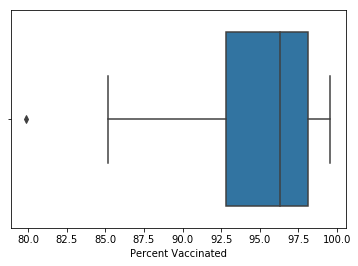

In [15]:
# Some visualizations of the vacination rates
sns.boxplot(x='Percent Vaccinated', data=merged_df)

count    58.000000
mean     95.283966
std       3.772534
min      79.860000
25%      92.812500
50%      96.305000
75%      98.122500
max      99.560000
Name: Percent Vaccinated, dtype: float64


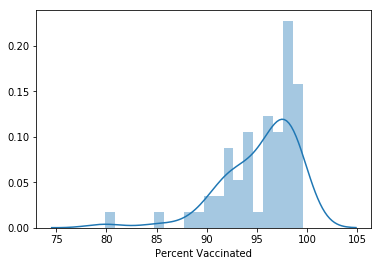

In [16]:
# Some Descriptive data and Probabability density function, looking for outliers
num_of_bins = 20
print(merged_df['Percent Vaccinated'].describe())
sns.distplot(merged_df['Percent Vaccinated'], bins=num_of_bins)

In [17]:
# Look at the least vaccinated counties
merged_df.head()

,County,n,exemptions,Percent Vaccinated,High School Graduate,Bachelors,Graduate Degree,High School or Higher,Bachelors or Higher,No High School Diploma,Population,Percent Insured,Median Income,Mean Income,Per capita income,Mean - Median,Unemployment Percentage
28,Nevada,3998,805,79.86,20.8,21.4,11.4,94.3,32.8,5.7,97694,85.5,56949,75742,32117,18793,6.0
52,Trinity,473,70,85.20,27.7,16.8,5.2,90.7,22.0,9.4,13304,79.4,36862,52729,23145,15867,6.1
54,Tuolumne,2331,265,88.63,28.7,13.5,6.3,89.6,19.8,10.4,50986,87.8,48493,62446,26063,13953,7.5
11,Humboldt,7511,789,89.50,25.9,18.5,9.0,90.3,27.5,9.6,133758,81.2,42153,56409,23516,14256,6.7
46,Siskiyou,2211,211,90.46,26.0,16.2,7.8,88.8,24.0,11.2,44035,85.8,37495,50453,22482,12958,7.5


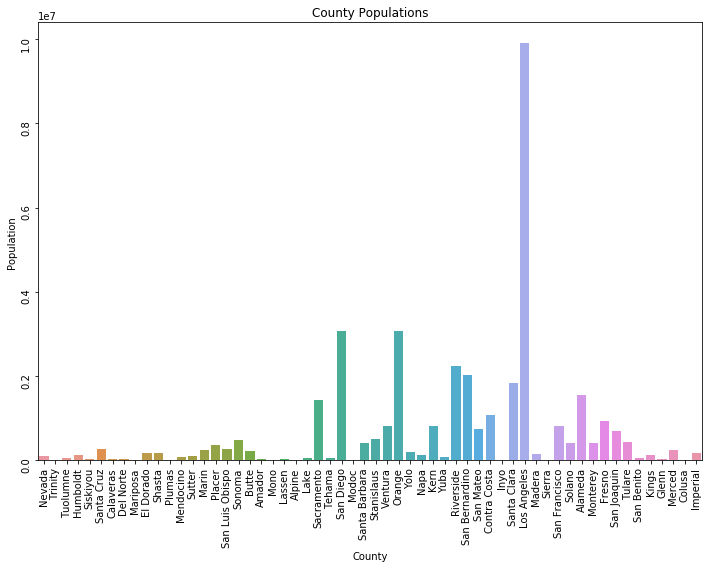

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='County', y='Population', data=merged_df, ax=ax)
ax.tick_params(rotation=90)
ax.set_title('County Populations')
fig.tight_layout()

## Visualizations Explorations

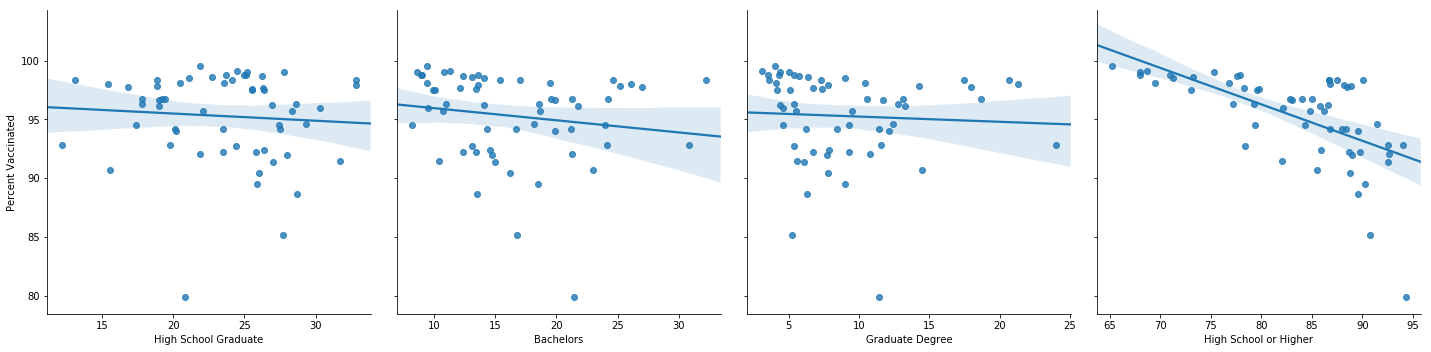

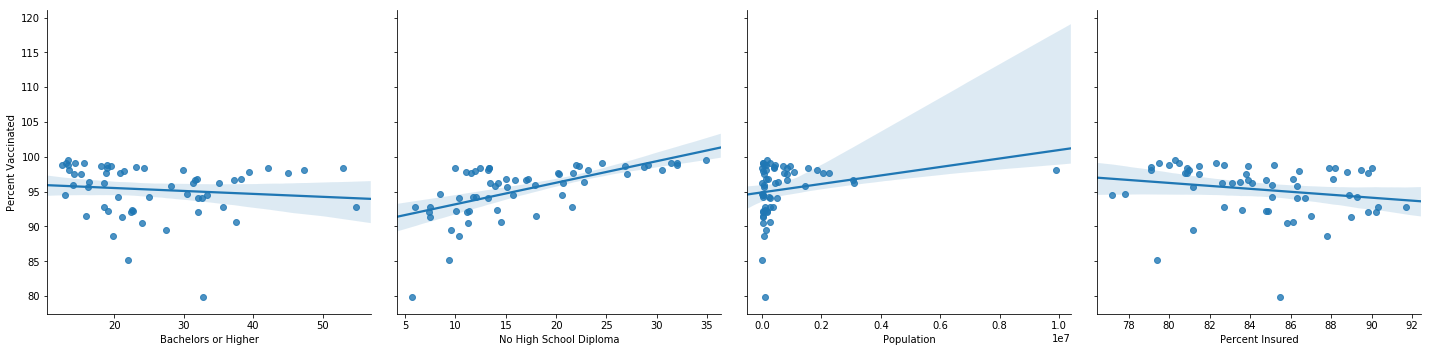

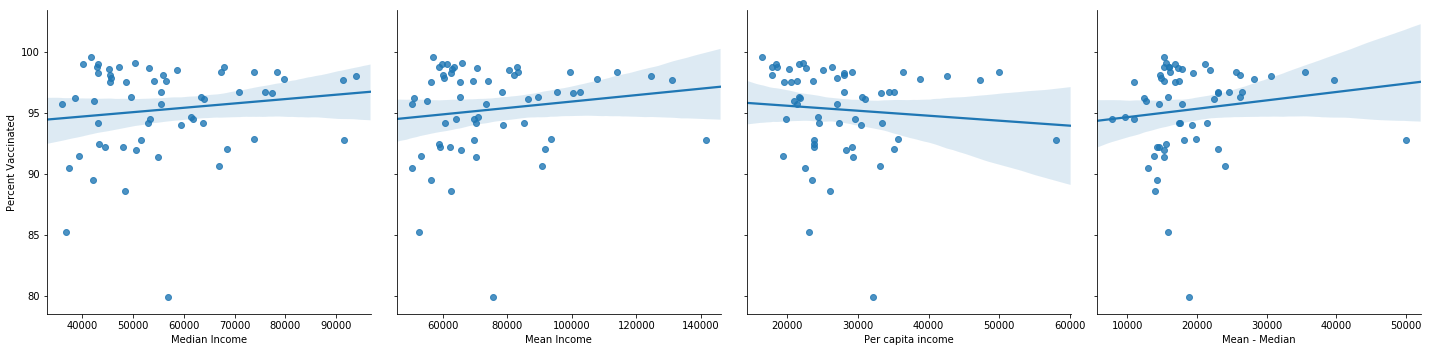

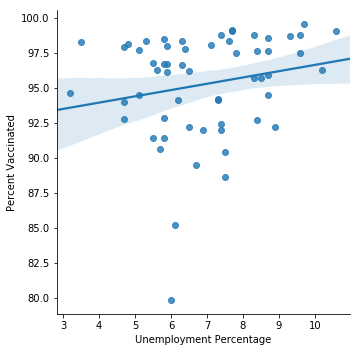

In [19]:
# Look at bubble plots for different independent variables
ind_cols = merged_df.columns[4:]
ind_cols

for idx in range(0, len(ind_cols), 4):
    sns.pairplot(merged_df, y_vars='Percent Vaccinated', x_vars=ind_cols[idx: idx+4], kind='reg',height=5)

## Education Analysis

In [20]:
# Look at linear regression for the High Schol or Higher group
X = merged_df['High School or Higher']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     33.76
Date:                Tue, 02 Apr 2019   Prob (F-statistic):           3.08e-07
Time:                        19:15:09   Log-Likelihood:                -145.12
No. Observations:                  58   AIC:                             294.2
Df Residuals:                      56   BIC:                             298.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   121.04

/Users/TheDoctor/.virtualenvs/data-analysis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [21]:
# Look at Bachelors or higher
X = merged_df['Bachelors or Higher']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7838
Date:                Tue, 02 Apr 2019   Prob (F-statistic):              0.380
Time:                        19:15:09   Log-Likelihood:                -158.40
No. Observations:                  58   AIC:                             320.8
Df Residuals:                      56   BIC:                             324.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  96.3608    

#### Findings
What does it mean to have a low p-value and a low r-squared value for High School or Higher Education regression model
    - There seems to be a correlation but there's also a lot of variance hurting the predictive capabilities of the model

### Considering Bachelors or Higher has no correlation, but High School or Higher does. Let's look at them on a more individual basis.

In [22]:
# High School Diploma
X = merged_df['No High School Diploma']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     33.61
Date:                Tue, 02 Apr 2019   Prob (F-statistic):           3.24e-07
Time:                        19:15:09   Log-Likelihood:                -145.17
No. Observations:                  58   AIC:                             294.3
Df Residuals:                      56   BIC:                             298.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     90

In [23]:
# High School Diploma
X = merged_df['High School Graduate']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.3305
Date:                Tue, 02 Apr 2019   Prob (F-statistic):              0.568
Time:                        19:15:09   Log-Likelihood:                -158.63
No. Observations:                  58   AIC:                             321.3
Df Residuals:                      56   BIC:                             325.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   96.7226 

In [24]:
# Bachelors
X = merged_df['Bachelors']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.493
Date:                Tue, 02 Apr 2019   Prob (F-statistic):              0.227
Time:                        19:15:09   Log-Likelihood:                -158.04
No. Observations:                  58   AIC:                             320.1
Df Residuals:                      56   BIC:                             324.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.9888      1.480     65.544      0.0

In [25]:
# Graduate
X = merged_df['Graduate Degree']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.1859
Date:                Tue, 02 Apr 2019   Prob (F-statistic):              0.668
Time:                        19:15:09   Log-Likelihood:                -158.71
No. Observations:                  58   AIC:                             321.4
Df Residuals:                      56   BIC:                             325.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              95.6835      1.052     

There doesn't appear to be any correlation with any of the individual education ranges.

#### Findings
There is a significant **positive** correlation between the percentage of the population no High School Diploma and percent vacinated.

## Insurance

In [26]:
# Percent Insured
X = merged_df['Percent Insured']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.478
Date:                Tue, 02 Apr 2019   Prob (F-statistic):              0.121
Time:                        19:15:09   Log-Likelihood:                -157.55
No. Observations:                  58   AIC:                             319.1
Df Residuals:                      56   BIC:                             323.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             113.2263     11.409     

In [27]:
# Unemployment Rate
X = merged_df['Unemployment Percentage']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.270
Date:                Tue, 02 Apr 2019   Prob (F-statistic):              0.138
Time:                        19:15:09   Log-Likelihood:                -157.65
No. Observations:                  58   AIC:                             319.3
Df Residuals:                      56   BIC:                             323.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Finding: Suprisingly enough, there appears to be no correlation between the uninsured rate and percent vaccinated

In [28]:
# Unemployment Rate
X = merged_df['Mean - Median']
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.007
Date:                Tue, 02 Apr 2019   Prob (F-statistic):              0.320
Time:                        19:15:09   Log-Likelihood:                -158.29
No. Observations:                  58   AIC:                             320.6
Df Residuals:                      56   BIC:                             324.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            93.9690      1.401     67.077

## Multi-variant Analysis

In [29]:
# Lets look at median income coupled with no High School Diploma
# Unemployment Rate
X = merged_df[['No High School Diploma', 'Median Income']]
Y = merged_df['Percent Vaccinated']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predication = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     Percent Vaccinated   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     26.72
Date:                Tue, 02 Apr 2019   Prob (F-statistic):           7.81e-09
Time:                        19:15:09   Log-Likelihood:                -139.12
No. Observations:                  58   AIC:                             284.2
Df Residuals:                      55   BIC:                             290.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     83

# Findings and Next Steps
## Findings
The following demographic indicators appear to have not correlation or predictive capability for the level of vaccination:
- Income
- Employment Rate
- Insured Rate

Education seems to have some correlation with the uninsured rate. Interestingly though the only significant indicator seems to be the percent of the population with *No High School Diploma*. 

The 